In [1]:
using DrWatson
@quickactivate "FenrirForNeuro"
using CairoMakie
using CSV, DataFrames
using Printf
using Statistics, LinearAlgebra

Axis = CairoMakie.Axis

Makie.Axis

In [2]:
# helpers
function import_csvs(path, fnames, header=nothing)
    dfs = []
    for fname in fnames
        fpath = joinpath(path, fname)
        df = CSV.read(fpath, DataFrame, header=false)
        if header != nothing
            rename!(df, header)
        end
        push!(dfs, df)
    end
    return dfs
end

function where_converged(trajectories, threshold=5e-2)
    last_rows = get_last_rows(trajectories)
    pRMSEs = map(x -> rel_pRMSE(x, pvalues(θ)), eachrow(Array(last_rows[!, pkeys(θ)])))
    return pRMSEs .< 5e-2
end

θ = [Pair(:gNa, 25), Pair(:gK, 7)]
pkeys(θ) = map(θᵢ -> Symbol(θᵢ[1]), θ)
pvalues(θ) = map(θᵢ -> θᵢ[2], θ)

get_last_rows(trajectories) = vcat([DataFrame(t[end, :]) for t in trajectories]...)

get_last_rows (generic function with 1 method)

In [3]:
HALF_WIDTH = ((6.75 - 0.25) / 2) # inches
FULL_WIDTH = 6.75 # inches
HEIGHT = 0.9 * 3.25 # inches

PT_PER_INCH = 72
HALF_WIDTH *= PT_PER_INCH
FULL_WIDTH *= PT_PER_INCH
HEIGHT *= PT_PER_INCH

RESULTS_PATH = "../../results/"
FIGURES_PATH = "../../figures/"

PLOT_DEFAULTS = (titlesize=7, xlabelsize=7, ylabelsize=7, xticklabelsize=7, yticklabelsize=7, xticksize=2, yticksize=2)

(titlesize = 7, xlabelsize = 7, ylabelsize = 7, xticklabelsize = 7, yticklabelsize = 7, xticksize = 2, yticksize = 2)

In [4]:
function rel_pRMSE(θ_hat, θ)
    θ_hat = ndims(θ_hat) == 1 ? reshape(θ_hat, length(θ_hat), 1) : θ_hat
    MSE = sum(abs2, (θ_hat .- θ) ./ θ) / size(θ, 1)
    RMSE = sqrt.(MSE)
    return RMSE
end

rel_pRMSE (generic function with 1 method)

In [5]:
BASE_PATH = RESULTS_PATH * "hh/2p/simple/"

tempering_schedule = reverse([10.0^x for x in 0:20])

metrics = []

max, max_idx = (0, 0)
final_opt_steps = []
for (i, T) in enumerate(tempering_schedule)
    fnames = readdir(BASE_PATH * "fenrir/compare_fixed_diff")
    fnames = fnames[map(x -> occursin("-$i-", x), fnames)]
    trajectories = import_csvs(BASE_PATH * "fenrir/compare_fixed_diff", fnames, [pkeys(θ)..., :κ², :loss, :T])
    last_rows = get_last_rows(trajectories)
    push!(final_opt_steps, last_rows)
    conv = where_converged(trajectories)

    if mean(conv) > max
        max = mean(conv)
        max_idx = i
    end
    push!(metrics, conv)
end

# high, low, best κ²
metrics = [metrics[end], metrics[1], metrics[max_idx]]

# optimal κ²
trajectories = import_csvs(BASE_PATH * "fenrir/opt_fixed_diff", readdir(BASE_PATH * "fenrir/opt_fixed_diff"), [pkeys(θ)..., :κ², :loss, :T])
last_rows = get_last_rows(trajectories)
optimal_κ² = mean(log10.(last_rows[!, :κ²]))
push!(metrics, where_converged(trajectories))

println("best κ²= $(tempering_schedule[max_idx]) -> $(max*100)% correct")

best κ²= 1.0e16 -> 84.0% correct


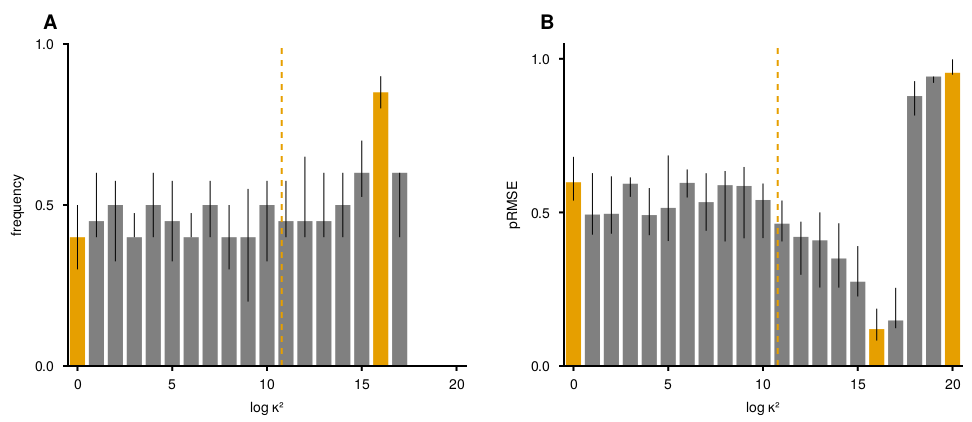

In [6]:
calibrations = [@sprintf("%.0e", c) for c in tempering_schedule]


f = Figure(size=(FULL_WIDTH, HEIGHT), figure_padding=5)
ax1 = Axis(f[1, 1], ylabel="frequency", xlabel="log κ²"; PLOT_DEFAULTS...)
ax2 = Axis(f[1, 2], ylabel="pRMSE", xlabel="log κ²"; PLOT_DEFAULTS...)

for (i, (last_row, cal)) in enumerate(zip(final_opt_steps, tempering_schedule))
    θ_est = last_row[!, pkeys(θ)]
    dₚ = map(x->rel_pRMSE(x, pvalues(θ)), eachrow(Array(θ_est)))
    last_row[!, :d_p] = [dₚ...]
    last_row[!, :conv] = [(dₚ .< 5e-2)...]

    conv = Array(last_row[!, :conv])
    conv = vcat(conv, zeros(100 - size(conv, 1)))
    conv = reshape(conv, 10, 10)
    μ_conv = reshape(mean(conv, dims=1), :)
    m_conv = median(μ_conv)
    ql_conv = quantile(μ_conv, 0.25)
    qu_conv = quantile(μ_conv, 0.75)

    dₚ = vcat(dₚ, zeros(100 - size(dₚ, 1)))
    dₚ = reshape(dₚ, 10, 10)
    μ_dₚ = reshape(mean(dₚ, dims=1), :)
    m_dₚ = median(μ_dₚ)
    ql_dₚ = quantile(μ_dₚ, 0.25)
    qu_dₚ = quantile(μ_dₚ, 0.75)

    barplot!(ax1, log10.(cal), m_conv, color=i in [1, max_idx, length(tempering_schedule)] ? Makie.wong_colors()[2] : :grey)
    errorbars!(ax1, [log10.(cal)], [m_conv], [m_conv - ql_conv], [qu_conv - m_conv], color=:black, linewidth=0.5)

    barplot!(ax2, log10.(cal), m_dₚ, color=i in [1, max_idx, length(tempering_schedule)] ? Makie.wong_colors()[2] : :grey)
    errorbars!(ax2, [log10.(cal)], [m_dₚ], [m_dₚ - ql_dₚ], [qu_dₚ - m_dₚ], color=:black, linewidth=0.5)

    # barplot!(ax1, i, mean(μ_conv))

    # boxplot!(ax1, fill(i, 10), μ_conv)
end

vlines!(ax1, [optimal_κ²], color=Makie.wong_colors()[2], linewidth=1, linestyle=:dash)
vlines!(ax2, [optimal_κ²], color=Makie.wong_colors()[2], linewidth=1, linestyle=:dash)

ylims!(ax1, 0, 1)
ylims!(ax2, 0, nothing)
xlims!(ax1, -0.5, 20.5)
xlims!(ax2, -0.5, 20.5)
hidedecorations!(ax1, grid=true, label=false, ticks=false, ticklabels=false)
hidedecorations!(ax2, grid=true, label=false, ticks=false, ticklabels=false)
hidespines!(ax1, :t, :r)
hidespines!(ax2, :t, :r)

colgap!(f.layout, Relative(0.05))

Label(f.layout[1, 1, TopLeft()], "A", fontsize=10, font=:bold, padding=(0, 5, 5, 0), halign=:right)
Label(f.layout[1, 2, TopLeft()], "B", fontsize=10, font=:bold, padding=(0, 5, 5, 0), halign=:right)

f

In [8]:
save(joinpath(FIGURES_PATH, "appendix_figure5.pdf"), f, overwrite=true)


CairoMakie.Screen{PDF}
